# Tutorial 7 - Neuromorphic Datasets with Tonic + snnTroch

## Learn how to
- load neuromorphic datasets using Tonic
- make use of chaching to speed up dataloading
- train a ConvSNN with the N-MNIST dataset

> Tonin 라이브러리를 활용하여 Neuromorphic 데이터셋을 로드하고 학습하는 과정에 대해 알아본다.

# 1. Using Tonic to load Neuromorphic datasets

Tonic 라이브러리는 Pytorch vision과 비슷하게 작동한다. Tonic을 사용하여 N-MNIST와 같은 neuromorphic 데이터셋을 로드할 수 있다.

In [1]:
import tonic
import numpy as np

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)       # 9~0, total 60,000
events, target = dataset[0]
print(events)       # [(x,y,timestamp,polarity), (x,y,timestamp,polarity), ...]
print(type(events))
print(np.shape(events))
print(type(dataset), len(dataset), type(dataset[0]), dataset[0])
print(target)

/home/user/python_ws/SNN-Torch-Practice/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[( 0, 30,   1213, 1) ( 9, 18,   4044, 0) (30, 15,   4104, 1) ...
 ( 9, 17, 301658, 0) (18,  8, 305112, 1) (19, 26, 309976, 1)]
<class 'numpy.ndarray'>
(3913,)
<class 'tonic.datasets.nmnist.NMNIST'> 60000 <class 'tuple'> (array([( 0, 30,   1213, 1), ( 9, 18,   4044, 0), (30, 15,   4104, 1), ...,
       ( 9, 17, 301658, 0), (18,  8, 305112, 1), (19, 26, 309976, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]), 9)
9


위와 같이 N-MNIST 데이터셋을 로드할 수 있다. MNIST와 동일하게 총 6만장의 이미지가 있으며, 각 이미지들을 $ms$ 단위의 event들로 재생성한 것이다. events는 수천개 이벤트들의 리스트이고, 하나의 이벤트는 (x, y, timestamp, polarity)로 표현된다. *polarity* 는 $+1\ or\ -1$ 이며, 빛의 밝기가 밝아지거나 어두워지거나 둘 중 하나이다.

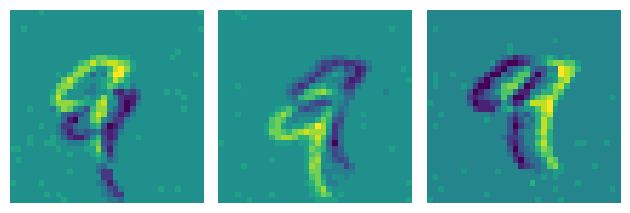

In [2]:
tonic.utils.plot_event_grid(events)

## 1.1 Transformation
위와 같은 raw 데이터를 네트워크의 입력으로 사용할 수 없다. Pytorch dataset과 비슷하게 텐서로의 변환 과정이 필요하다.

In [3]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time-window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, time_window=1000)])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset  = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

## 1.2 Fast data loading via caching
데이터 캐싱을 통해 데이터를 로드하는데 시간을 줄일 수 있다.

In [4]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]
        
%timeit -o load_sample_simple()

467 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 467 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

Pytorch DataLoader와 디스크 캐싱을 통해 위 시간을 줄일 수 있다.

In [5]:
from torch.utils.data import DataLoader
from tonic import CachedDataset

cached_trainset   = CachedDataset(trainset, cache_path='./cache/nmist/train')
cached_dataloader = DataLoader(cached_trainset)

def load_sample_cached():
    for i, (events, target) in enumerate(iter(cached_dataloader)):
        if i > 99: break
        
%timeit -o -r 20 load_sample_cached()

/tmp/ipykernel_14558/1546661115.py:4: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  cached_trainset   = CachedDataset(trainset, cache_path='./cache/nmist/train')


221 ms ± 4.51 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


<TimeitResult : 221 ms ± 4.51 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)>

## 1.3 Even faster dataloading via batching

데이터 로딩 시간을 줄였다. 이제 GPU를 더욱 효율적으로 사용하기 위해 batching 한다.

각각의 이벤트들은 기록 시간이 모두 다르기 때문에, **tonic.collation.PadTensors()** 함수를 사용하여 batch 내부의 모든 데이터들이 같은 디멘션을 가질 수 있도록해준다. 기록 시간이 짧은 것들을 pad out하는 방식을 사용한다.

In [6]:
batch_size = 100

trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

def load_sample_batched():
    events, target = next(iter(cached_dataloader))
    
%timeit -o -r 10 load_sample_batched()

3.79 ms ± 5.87 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 3.79 ms ± 5.87 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

# 2. Training our network using frames created from events

Training data에 augmentation을 적용하고자 한다. 캐싱된 데이터셋에서 가져온 샘플들은 프레임(텐서)이기 때문에, torchvision을 적용할 수 있다.

In [7]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy, 
                                      torchvision.transforms.RandomRotation([-10, 10])])

cached_trainset = CachedDataset(trainset, transform=transform, cache_path='./cache/nmist/train')
# No augmentation for the testset
cached_testset  = CachedDataset(testset, cache_path='./cache/nmist/test')

batch_size  = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(), shuffle=True)
testloader  = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

/tmp/ipykernel_14558/1859081736.py:7: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  cached_trainset = CachedDataset(trainset, transform=transform, cache_path='./cache/nmist/train')
/tmp/ipykernel_14558/1859081736.py:9: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  cached_testset  = CachedDataset(testset, cache_path='./cache/nmist/test')


하나의 미니배치는 다음과 같은 파일 포맷을 가진다.

> (batch_size, time_steps, channels, height, width)

여기서 *time_steps*는 미니배치에 있는 데이터 중 이벤트의 길이가 가장 긴 데이터에 맞춰진다. 그리고 다른 데이터들의 모자란 부붙은 0으로 채워진다.

In [8]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([128, 311, 2, 34, 34])


## 2.1 Defining our network

Pytorch와 snnTorch를 사용하여 ConvSNN을 설계한다. 아키텍처는 다음과 같다.

> 12C5-MP2-32C5-MP2-800FC10

In [9]:
import snntorch as snn
from snntorch import surrogate, utils
from snntorch import functional as SF
from snntorch import spikeplot as splt

import torch.nn as nn

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Neuron and simulation params
spike_grad = surrogate.fast_sigmoid(slope=75)
beta       = 0.5

# Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5), 
                    nn.MaxPool2d(2), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True), 
                    nn.Conv2d(12, 32, 5), 
                    nn.MaxPool2d(2), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True), 
                    nn.Flatten(), 
                    nn.Linear(32*5*5, 10), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)).to(device)

In [11]:
# Do not return membrane as we don't need it

def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)        # Reset hidden states for all LIF neurons in net
    
    print(data.shape)
    data = data.transpose(0,1)
    print(data.shape)
    for step in range(data.size(0)):        # data.size(0) = num of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
        
    return torch.stack(spk_rec)

## 2.2 Training

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break

torch.Size([128, 310, 2, 34, 34])
torch.Size([310, 128, 2, 34, 34])
Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 3.91%

torch.Size([128, 311, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 9.38%

torch.Size([128, 311, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
Epoch 0, Iteration 2 
Train Loss: 30.90
Accuracy: 6.25%

torch.Size([128, 312, 2, 34, 34])
torch.Size([312, 128, 2, 34, 34])
Epoch 0, Iteration 3 
Train Loss: 30.96
Accuracy: 8.59%

torch.Size([128, 311, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
Epoch 0, Iteration 4 
Train Loss: 30.90
Accuracy: 9.38%

torch.Size([128, 312, 2, 34, 34])
torch.Size([312, 128, 2, 34, 34])
Epoch 0, Iteration 5 
Train Loss: 30.96
Accuracy: 9.38%

torch.Size([128, 313, 2, 34, 34])
torch.Size([313, 128, 2, 34, 34])
Epoch 0, Iteration 6 
Train Loss: 31.02
Accuracy: 13.28%



In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
idx = 127       # At minibatch

print(f"The target label is: {targets[idx]}")

tonic.utils.plot_event_grid(data[idx])